In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

In [20]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

In [21]:
df = pd.read_excel("amazon.xlsx")

In [22]:
df['Review'] = df['Review'].str.lower()
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)
df['Review'] = df['Review'].str.replace('\d', '', regex=True)

In [24]:
stop_words = stopwords.words('english')
df['Review'] = df['Review'].astype(str).apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

In [25]:
least_frequent_words = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(word for word in x.split() if word not in least_frequent_words))


In [26]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


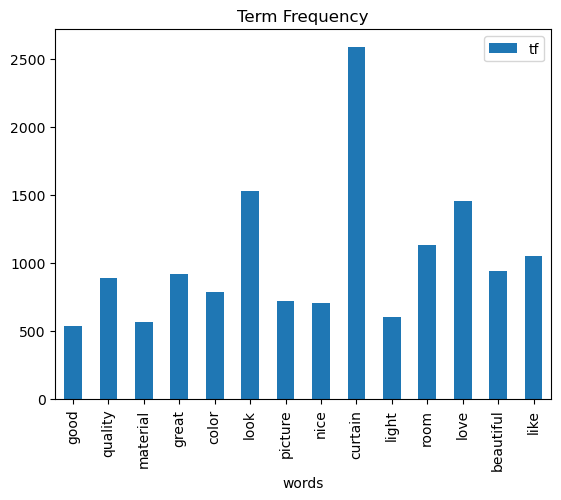

In [27]:
term_frequency = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
term_frequency.columns = ["words", "tf"]
term_frequency[term_frequency["tf"] > 500].plot.bar(x="words", y="tf")
plt.title('Term Frequency')
plt.show()

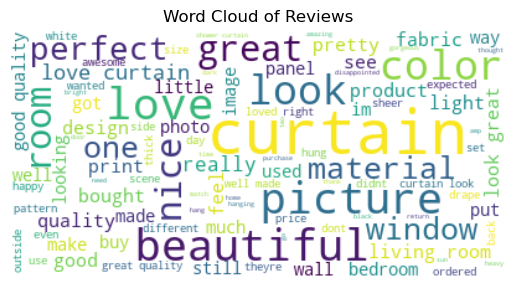

In [28]:
wordcloud_text = " ".join(df.Review)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(wordcloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud of Reviews')
plt.show()


In [29]:
sia = SentimentIntensityAnalyzer()
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")


In [30]:
print(df.groupby("Sentiment_Label")["Star"].mean())


Sentiment_Label
neg   3.39
pos   4.59
Name: Star, dtype: float64


In [31]:
train_x, test_x, train_y, test_y = train_test_split(df["Review"], df["Sentiment_Label"], random_state=42)


In [32]:
tf_idf_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf = tf_idf_vectorizer.transform(train_x)
x_test_tf_idf = tf_idf_vectorizer.transform(test_x)

In [33]:
log_model = LogisticRegression()
log_model.fit(x_train_tf_idf, train_y)
y_pred = log_model.predict(x_test_tf_idf)
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

         neg       0.90      0.33      0.49       223
         pos       0.89      0.99      0.94      1180

    accuracy                           0.89      1403
   macro avg       0.89      0.66      0.71      1403
weighted avg       0.89      0.89      0.87      1403



In [34]:
log_accuracy = cross_val_score(log_model, x_test_tf_idf, test_y, cv=5).mean()
print(f'Cross-validated accuracy (Logistic Regression): {log_accuracy:.2f}')


Cross-validated accuracy (Logistic Regression): 0.85


In [35]:
random_review = df["Review"].sample(1).values
new_review_tf_idf = tf_idf_vectorizer.transform(random_review)
pred = log_model.predict(new_review_tf_idf)
print(f'Review: {random_review[0]} \nPrediction: {pred[0]}')

Review: look nice living room bought four panel make one big picture 
Prediction: pos


In [36]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_tf_idf, train_y)
rf_accuracy = cross_val_score(rf_model, x_test_tf_idf, test_y, cv=5).mean()
print(f'Cross-validated accuracy (Random Forest): {rf_accuracy:.2f}')

Cross-validated accuracy (Random Forest): 0.89


In [37]:
print(f'Logistic Regression accuracy: {log_accuracy:.2f}, Random Forest accuracy: {rf_accuracy:.2f}')

Logistic Regression accuracy: 0.85, Random Forest accuracy: 0.89
